# Cartpole Neuroevolution

This tutorial uses a evolution to train a neural network to solve the CartPole-v1 environment in OpenAI gym

In [2]:
import gym
import numpy as np
from itertools import count
from collections import namedtuple

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

In [4]:
import pygad
import pygad.torchga

## Initialize the environment

We have 4 variables in our observation and 2 actions in this problem

In [18]:
env = gym.make('CartPole-v1')

In [19]:
env.observation_space, env.action_space

(Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32),
 Discrete(2))

## Neural Network

A simple neural network. This is sufficient to solve the problem.

In [20]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_in, n_out):
        super(NeuralNetwork, self).__init__()
        
        self.linear1 = nn.Linear(n_in, 16)
        self.linear2 = nn.Linear(16, 32)
        self.linear3 = nn.Linear(32, n_out)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
        
    def forward(self, x):
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        x = self.linear3(x)
        return self.softmax(x)

In [21]:
model = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
model = model.float() # Otherwise it will complain saying that it expects "Double" but got "Float"

This `select_action` function is a simple function that just processes the output of the network and picks the action. It suffices for the problem. For a more complex problem, you should add something like epsilon-greedy exploration, so that the model doesnt just converge on a local optimum

In [22]:
def select_action(model, state): # A more complicated select_action function will also add some exploration
    outputs = model(torch.FloatTensor(state))
    return torch.argmax(outputs).item()

In [24]:
rewards = []

## Fitness Function

Here is our fitness function. Note the fitness function runs an 1 episode of Cartpole and returns the reward of that. Our fitness value will be the reward. Our goal is to get the running reward to 195.

In [25]:
def fitness_func(solution, sol_idx):
    model.load_state_dict(pygad.torchga.model_weights_as_dict(model, solution))
    
    episode_reward = 0
    state = env.reset()
    for i in range(10000):
        action = select_action(model, state)
        state, reward, done, _ = env.step(action)
        episode_reward += reward
        if done: 
            break
            
    rewards.append(episode_reward)
    return episode_reward

We stop the GA if the running reward reaches 195 or higher

In [26]:
def generation_callback(instance):
    print(f"Generation: {instance.generations_completed}")
    print(f"Fitness: {instance.best_solution()[1]}")
    print(f"Running Reward: {np.mean(rewards[-20:])}")
    if np.mean(rewards[-20:]) > env.spec.reward_threshold:
        return "stop"

## Train the model

Initialize the model with 10 solutions (i.e 10 neural networks)

In [27]:
gamodel = pygad.torchga.TorchGA(model, 10)

We will run for 250 generations, our mating pool will consist of the 5 best networks (or half the population)

In [28]:
num_generations = 250
num_parents_mating = 5
initial_population = gamodel.population_weights

Create the GA instance. In this, we decide to mutate only 15% of each offspring's parameters.

In [29]:
ga_instance = pygad.GA(num_generations=num_generations, num_parents_mating=num_parents_mating, 
                      fitness_func = fitness_func, initial_population=gamodel.population_weights, 
                      on_generation=generation_callback, mutation_percent_genes=15)

Our genetic algorithm solves the problem within 50 generations.

In [30]:
ga_instance.run()

Generation: 1
Fitness: 74.0
Running Reward: 19.5
Generation: 2
Fitness: 124.0
Running Reward: 33.35
Generation: 3
Fitness: 82.0
Running Reward: 20.5
Generation: 4
Fitness: 140.0
Running Reward: 35.3
Generation: 5
Fitness: 455.0
Running Reward: 64.2
Generation: 6
Fitness: 180.0
Running Reward: 48.45
Generation: 7
Fitness: 197.0
Running Reward: 62.05
Generation: 8
Fitness: 500.0
Running Reward: 81.6
Generation: 9
Fitness: 500.0
Running Reward: 166.2
Generation: 10
Fitness: 500.0
Running Reward: 133.35
Generation: 11
Fitness: 500.0
Running Reward: 190.6
Generation: 12
Fitness: 500.0
Running Reward: 172.5
Generation: 13
Fitness: 500.0
Running Reward: 175.15
Generation: 14
Fitness: 500.0
Running Reward: 232.05
Generation: 15
Fitness: 500.0
Running Reward: 155.75
Generation: 16
Fitness: 500.0
Running Reward: 221.95
Generation: 17
Fitness: 500.0
Running Reward: 228.25
Generation: 18
Fitness: 500.0
Running Reward: 251.7
Generation: 19
Fitness: 500.0
Running Reward: 206.45
Generation: 20
Fitnes

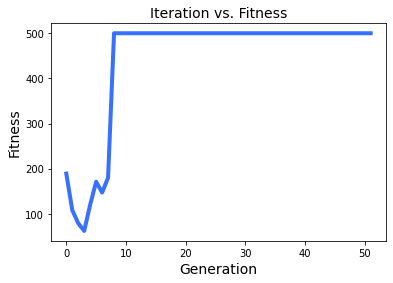

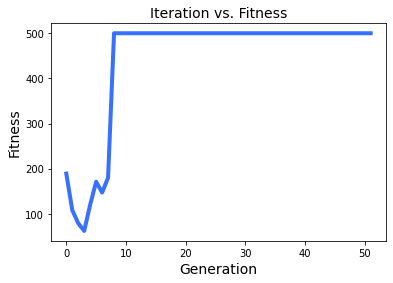

In [31]:
ga_instance.plot_fitness(title="Iteration vs. Fitness", linewidth=4)

Our genetic algorithm learned to solve the problem around generation 10, and the running reward hit 500 at generation 50

## Test the model

**Make sure to always load in the best solution**

In [32]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
model.load_state_dict(pygad.torchga.model_weights_as_dict(model, solution))

<All keys matched successfully>

This solution manages to solve the problem

In [33]:
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

Fitness value of the best solution = 500.0
Index of the best solution : 0


To run this, you need to have `ffmpeg` and `pyglet` installed. If you dont want to save a video of your environment, just comment the line that redefines `env`

You can install `ffmpeg` through the command `brew install ffmpeg` (*on macOS*). For pyglet, you can just use `pip3 install pyglet`

In [34]:
from gym import wrappers
env = wrappers.Monitor(env, 'cartpole-v1', force=True) # Comment out this line if you dont need a video

In [35]:
episode_reward = 0
state = env.reset()
for i in range(10000):
    action = select_action(model, state)
    state, reward, done, _ = env.step(action)
    episode_reward += reward
    if done: 
        break
env.close()

You can see here that the cartpole ran the full expected duration

In [36]:
episode_reward

500.0

Thanks for reading this tutorial. See you in the next one